In [1]:
import sys, os
import numpy as np
import torch
print(torch.__version__)

import matplotlib.pyplot as plt
%matplotlib inline

1.4.0


In [ ]:
# Test
t = torch.linspace(-10, 10, steps=10000)

# compute x(t) and y(t) as defined above
x = t - 1.5 * (15*t).cos()
y = t - 1.5 * (14*t).sin()

plt.plot(x.numpy(), y.numpy())


In [ ]:
# Boston house price
from sklearn.datasets import load_boston
boston = load_boston()
plt.scatter(boston.data[:, -1], boston.target)

boston.data[:]

In [ ]:
# Simple linear regression with PyTorch

w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

x = torch.tensor(boston.data[:, -1] / 10, dtype=torch.float32)
y = torch.tensor(boston.target, dtype=torch.float32)



In [ ]:
y_pred = w * x + b
loss = torch.mean((y_pred - y)**2)

# propagate gradients
loss.backward()
print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)


In [ ]:
from IPython.display import clear_output
for i in range(200):
    y_pred = w * x + b
    loss = torch.mean((y_pred - y)**2)
    loss.backward()

    # Update the weights, with lr == 0.05
    w.data -= 0.05 * w.grad.data
    b.data -= 0.05 * b.grad.data

    # zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()

    # the rest of code is just bells and whistles
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.scatter(x.numpy(), y.numpy())
        plt.scatter(x.numpy(), y_pred.detach().numpy(), color='orange', linewidth=5)
        plt.show()

        print("loss = ", loss.detach().numpy())
        if loss.detach().numpy() < 0.5:
            print("Done!")
            break


In [2]:
from DataLoader import notMNIST
dataset = notMNIST("/Users/czkaiweb/Research/DeepVision/dataset/notMNIST_small")

File A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png is broken
File F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png is broken


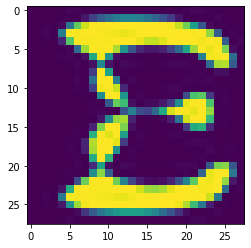

In [3]:
# Using DataLoader as generator to get item from notMNIST dataset
from torch.utils.data import DataLoader,Sampler
train_loader = DataLoader(dataset=dataset, batch_size=128, shuffle=True)

def display():
    for step, data in enumerate(train_loader,0):
        train_x, train_y = data
        plt.imshow(train_x[0].reshape([28, 28]))
        if step == 0:
            break
        
display()

In [ ]:
# A simpler way:
#from torchvision import datasets,transforms
#dataloader = datasets.ImageFolder(root="/Users/czkaiweb/Research/DeepVision/dataset/notMNIST_small")



In [4]:
## Start with layers
from torch import nn
print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super(Model, self).__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.
    


In [5]:
from Model import Model

model = Model()

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crossentropy = nn.CrossEntropyLoss()


In [6]:
loss_history = []
def train(epoch):
    maxstep = 0
    epoch_loss = 0
    n_batches = len(dataset)//128
    for step,data in enumerate(train_loader,0):
        train_x, train_y = data
        train_x  = train_x.reshape(-1,784)
        x = torch.tensor(train_x,dtype=torch.float32)
        y = torch.tensor(train_y,dtype=torch.float32)
        y_pred = model.forward(x)
        y_pred = y_pred.view(-1,10)
        # compute loss
        loss = crossentropy(y_pred,y.long())
        epoch_loss += loss.item()
        opt.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # adam step
        opt.step()
        
        # clear gradients
        opt.zero_grad()
        
        if step % n_batches == 0 and step != 0 and epoch%10 == 0:
            epoch_loss = epoch_loss / n_batches
            loss_history.append(epoch_loss)
            print("Epoch {}, loss {}".format(epoch, epoch_loss))
            epoch_loss = 0
            
for epoch in range(1, 101):
    train(epoch)

/opt/anaconda3/envs/Erdos/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/opt/anaconda3/envs/Erdos/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/Erdos/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/czkaiweb/Research/DeepVision/Model.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Ch

Epoch 10, loss 2.003589790161342
Epoch 20, loss 1.8347971186245957
Epoch 30, loss 1.7652716293726882
Epoch 40, loss 1.6603884394854715
Epoch 50, loss 1.6219551636748117
Epoch 60, loss 1.6085170589081228
Epoch 70, loss 1.6000593247478956
Epoch 80, loss 1.594302477901929
Epoch 90, loss 1.5894361922185716
Epoch 100, loss 1.585938373657122


In [9]:
## Evaluate 
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(train_loader,0):
        img,label = data
        img  = img.reshape(-1,784)
        output = model.forward(img)
        _,predict = torch.max(output.data,1)
        filterList = (predict == label)
        correct += filterList.sum().data
        total   += len(filterList)
        
        if i == 1:
            break
print("accurancy with test sample: {}".format(float(correct)/total))

accurancy with test sample: 0.90234375
